Using a t-statistic to find statistically significant gene expressions with multiple hypothesis testing

In [55]:
import csv
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

   golub.csv: matrix of gene expression levels for the 38 tumor mRNA
          samples, rows correspond to genes (3051 genes) and columns to
          mRNA samples.

golub_cl.csv: numeric vector indicating the tumor class, 27 acute
          lymphoblastic leukemia (ALL) cases (code 0) and 11 acute
          myeloid leukemia (AML) cases (code 1).

golub_gnames.csv: a matrix containing the names of the 3051 genes for the
          expression matrix ‘golub’. The three columns correspond to
          the gene ‘index’, ‘ID’, and ‘Name’, respectively.
~                                                              

In [3]:
filename = "data_and_materials/golub_data/golub.csv"

In [4]:
NUM_GENES = 3051
NUM_ALL = 27
NUM_AML = 11
N = NUM_ALL + NUM_AML

In [5]:
with open(filename, newline='') as csvfile:
    file_reader = csv.reader(csvfile, delimiter=',')
    golub_all = []
    golub_aml = []
    count = 0
    first_row = True
    for i in file_reader:
        if first_row:
            first_row = False
            continue
        golub_all.append(i[1:NUM_ALL + 1])
        golub_aml.append(i[NUM_ALL + 1:])


In [7]:
# Convert data to floats
all_data = []
for i in golub_all:
    all_data.append([float(j) for j in i])
aml_data = []
for i in golub_aml:
    aml_data.append([float(j) for j in i])

Null hypothesis is that all gene expression levels are picked from the same normal distribution. Use a t-statistic to accept or reject the hypothesis

In [43]:
# Calculate variances of distribution of patients for each gene
p_vals = []
all_vars = []
aml_vars = []
for i in range(NUM_GENES):
    all_mean = sum(all_data[i]) / NUM_ALL
    aml_mean = sum(aml_data[i]) / NUM_AML
    all_var = np.sum(np.square(np.asarray(all_data[i]) - all_mean))
    aml_var = np.sum(np.square(np.asarray(aml_data[i]) - aml_mean))
    all_vars.append(all_var / (NUM_ALL - 1))
    aml_vars.append(aml_var / (NUM_AML - 1))
    deg_freedom = NUM_ALL + NUM_AML - 2
    pooled_sample_var = (all_var + aml_var) / (deg_freedom)
    t_stat = (all_mean - aml_mean) / (np.sqrt(pooled_sample_var * (1/NUM_ALL + 1/NUM_AML)))
    cdf = stats.t.cdf(t_stat, deg_freedom)
    if (cdf < 0.5):
        p_vals.append(2 * cdf)
    else:
        p_vals.append(2 * (1 - cdf))

correlation:  [[1.         0.39612686]
 [0.39612686 1.        ]]


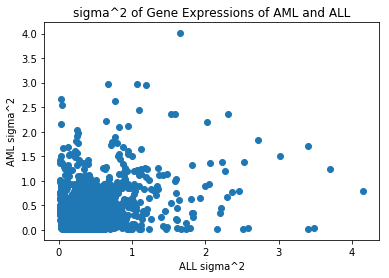

In [47]:
print("correlation: ", np.corrcoef(all_vars, aml_vars))
plt.scatter(all_vars, aml_vars)
plt.title("sigma^2 of Gene Expressions of AML and ALL")
plt.xlabel("ALL sigma^2")
plt.ylabel("AML sigma^2")
plt.show()

There is no obvious relationship between variances, so we will do a t-test without equal variances

In [51]:
p_vals_diff_var = []
for i in range(NUM_GENES):
    p_vals_diff_var.append(stats.ttest_ind(all_data[i], aml_data[i], equal_var = False)[1])
p_vals_enum = list(enumerate(p_vals_diff_var))
p_vals_enum.sort(key = lambda x: x[1])

In [56]:
# Count number of significant if alpha = 0.05
count = 0
for i in p_vals_enum:
    if i[1] < 0.05:
        count += 1
    else:
        break
print(count)

1078


In [61]:
# Multiple hypothesis test methods
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_vals_diff_var, alpha = 0.05, method = 'fdr_bh')
count = 0
for ind, i in enumerate(reject):
    if i:
        count += 1
print(count)